# C-M Interaction Curves
Note: a few [sample manual calculations](Example-BC05b.pdf) are also available, if you do not like reading Python code.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.figsize'] = [10,10]  # make plots a bit bigger

## 1. Rectangular Cross-Section

![shape](rectangular-shape.svg)

### Default Properties

In [3]:
b = 100.
d = 300.
Fy = 345.

### Function to calculate C and M corresponding to given $y_0$

In [4]:
def calcCM_R(y0,b=b,d=d,Fy=Fy):
    assert all(y0 >= 0.) and all(y0 <= d/2.)  # y0 can be an array of values
    C = 2.*y0*b*Fy * 1E-3
    # dist between T forces dt = d - 2*(d/2-y0)/2 = d/2+y0
    # M = T*dt
    M = (d/2.-y0)*b*Fy*(d/2.+y0) * 1E-6
    return C,M

### Sentinel values
  $C_y$ is axial force when $y_0=d/2$ (and $M=0$).  $M_p$ is moment when $y_0=0$ (and $C=0$).

In [5]:
zz,Mpr = calcCM_R(0.)
Cyr,zz = calcCM_R(d/2.)
print(Cyr,Mpr)

10350.0 776.25


Print values for checking when $y_0 = 0.2 d$:

In [6]:
C,M = calcCM_R(0.2*d)
print(0.2*d,C,M)

60.0 4140.0 652.05


These agree with the values on the [manual calculations](Example-BC05b.pdf).

### Now generate complete interaction curve

In [7]:
Cr,Mr = calcCM_R(linspace(0.,1.)*d/2)

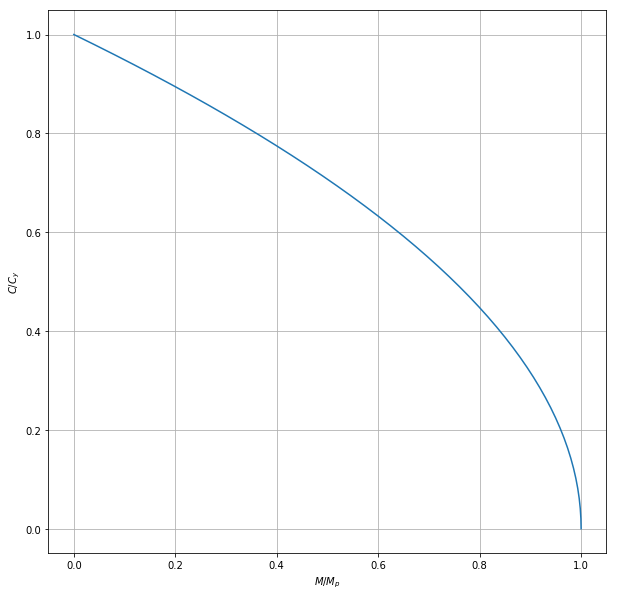

In [8]:
grid(True)
xlabel('$M/M_p$')
ylabel('$C/C_y$')
plot(Mr/Mpr,Cr/Cyr);

## 2. W-Shape Cross-Section

In [9]:
from Designer import sst, show
SST = sst.SST()

![w shape](W-Shape2.svg)

### Default dimensions (W250x73)

In [10]:
B,T,W,D,A,Zx = SST.section('W250x73',properties='B,T,W,D,A,Zx')
show('B,T,W,D,A,*1e3,Zx')

B  = 254       
T  = 14.2      
W  = 8.6       
D  = 253       
A  = 9280      
Zx = 985 * 1e3 


### Function to calculate C and M in a W-Shape corresponding to position of N.A. ($y_0$)

In [11]:
def calcCM_W(y0,B=B,T=T,D=D,W=W,Fy=Fy):
    H = D - 2.*T
    assert all(y0>=0.) and all(y0<=D/2.)  # y0 can be an array of values
    
    def case1(y0):   # y0 <= H/2
        C = 2.*y0*W*Fy * 1E-3
        T1 = (H/2.-y0)*W*Fy * 1E-3   # web
        T2 = B*T*Fy * 1E-3           # flange
        M = (T1*(y0+(H/2-y0)/2.)*2. + T2*(H/2.+T/2.)*2.) * 1E-3
        return C,M
    
    def case2(y0):   # y0 > H/2
        C1 = H*W*Fy * 1E-3             # web
        C2 = 2*(y0-H/2.)*B*Fy * 1E-3   # flange
        C = C1 + C2
        M = (D/2-y0)*B*Fy*(D-(D/2-y0)) * 1E-6    # could be simplified. who cares?
        return C,M
        
    if isscalar(y0):
        return case1(y0) if y0 <= H/2. else case2(y0)
        
    cm = array([case1(y) if y <= H/2 else case2(y) for y in y0])
    return cm[:,0],cm[:,1]

### Sentinel values
$M_p$ is moment when $y_0=0$ (and $C=0$).  $C_y$ is axial force when $y_0=d/2$ (and $M=0$).

In [12]:
zz,Mpw = calcCM_W(0.)
Cyw,zz = calcCM_W(D/2.)
Mpw,Cyw

(334.56752223, 3155.0802000000003)

The above values are about 1.5% less than values obtained directly using properties from the handbook.  I suspect that is difference due to fillets, etc.  For example, compare computed Area vs published:

In [13]:
Ac = 2*B*T + (D-2*T)*W
A,Ac,A/Ac

(9280.0, 9145.16, 1.0147444112514161)

Again, about 1.5% difference.

Now generate C,M values at $y_0 = H/4$ (halfway along web) and $y_0 = D/2 - T/2$ (halfway through flange) for checking.

In [14]:
y0 = (D-2.*T)/4.
C,M = calcCM_W(y0)
print(y0,C,M)
y0 = D/2 - T/2
C,M = calcCM_W(y0)
print(y0,C,M)

56.15 333.1941 325.21309787250004
119.4 1910.7342000000012 152.9923406999999


These agree with the values on the [manual calculations](Example-BC05b.pdf).

### Now generate complete interaction curve, for the W shape only.

In [15]:
Cw,Mw = calcCM_W(linspace(0.,1.)*D/2.)

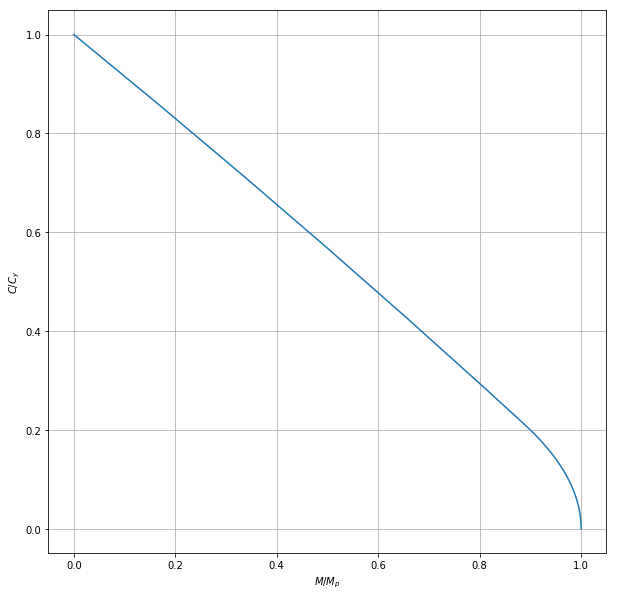

In [16]:
grid(True)
xlabel('$M/M_p$')
ylabel('$C/C_y$')
plot(Mw/Mpw,Cw/Cyw);

In [17]:
# comput 2 pts on the S16-14 curve:
# c/cy + 0.85*m/mp = 1;   c/cy = 1 - 0.85*m/mp
mrat = array([0.,1.])
crat = 1 - 0.85*mrat

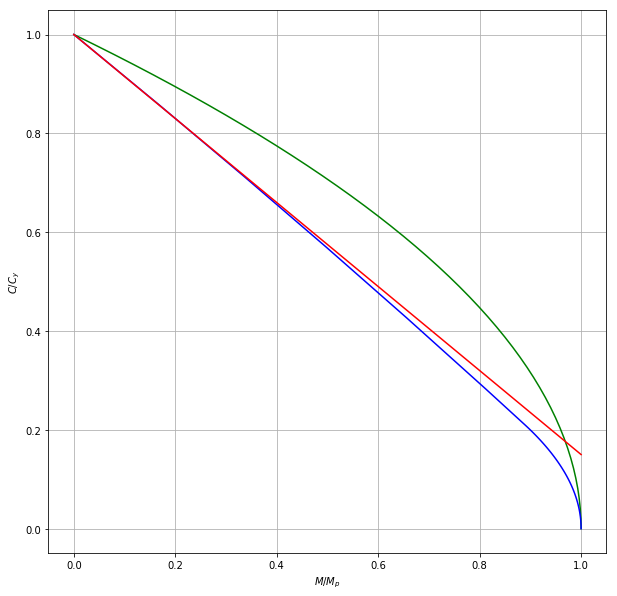

In [18]:
grid(True)
xlabel('$M/M_p$')
ylabel('$C/C_y$')

plot(Mr/Mpr,Cr/Cyr,'g',Mw/Mpw,Cw/Cyw,'b',mrat,crat,'r');

In the above, the blue line is for the W shape, the green line is for the rectangle (and has almost no significance), and the red line matches the basis of the interaction formulae in S16-14:

$$
\frac{C}{C_y} + 0.85 \frac{M}{M_p} \le 1
$$
